# **Hermes Tasks** - demo

In [1]:
# requirements for this demo
import time
import matplotlib.pyplot as plt
import numpy as np

This notebook is a demo of Hermes Tasks. I recommend you take a look at this, as a showcase of the main functionalities. More advanced details will be discussed in another notebook and/or in the documentation on [GitHub](https://github.com/baronefr/hermes).

<br>

## **Create a Task**

Creating a Task is very easy. First, we import the Hermes module 'task' and call the class initializer:

In [2]:
import hermes.task as htask
ht = htask(alias = 'demo')

[task] <demo> has been initialized [id:PR1K343]


<br> By default, if no alias is provided, Hermes will use a random identifier as alias of the task. If you want to use a custom alias, just use the optional argument 'alias':

```python
ht = htask(alias = 'myalias')
>>> [task] <myalias> has been initialized
```

Other useful options are:
- **allquiet**: if True, *all* the messages sent by the Telegram bot will be delivered without notifications.
- **logless**: disable Hermes integration with Hermes Bot.

Namely:
```python
ht = htask(logless = True, allquiet = True) # no local log & no sound notifications
```

Notice that you can **optionally silence individual notifications**, instead of all of them, just by using the `quiet` argument (more on this shortly).

<br>

### **[!]** non-blocking policy

This utility is designed for people who execute long codes and want to be updated on their execution status. In this context, I feel that **it is more important to guarantee that your code will continue to run** even in case of errors in Hermes.

For this reason, all the internals of Hermes are wrapped in a **failsafe exception manager**, which will just print the error message (on stderr) without stopping the execution. For example:

In [3]:
# note: this is intentionally wrong... :)
ht.notify(whatever_error = None)

print('but the show must go on!')

but the show must go on!


 [hermes] failsafe : task.notify() got an unexpected keyword argument 'whatever_error'


<br>

### **[!]** integration with Hermes Bot

In order to communicate with the Hermes Bot (be careful, Task != Bot), the Task has to write some log files. Prompting the flag `logless = True` will disable these interactions, and Hermes will not save any log of the execution. However, the task will not be available in the Hermes Bot. Look at the **advanced demo** for further discussion.

<br>

## **Notify**

The most simple functionality is to send custom text messages.

In [4]:
ht.notify('This is a demo of a task!')

As promised, you can send a message as **quiet**, i.e. no sound notification.

In [5]:
ht.notify('A silent message...', quiet = True)

<br>

### **notify an image**

The method notify can be used also to **send images**.

In [6]:
# download a picture in sample.jpg
!wget https://pbs.twimg.com/media/FaCBZ_sX0AIEpAw?format=jpg -O sample.jpg -q

In [7]:
ht.notify(img = 'sample.jpg', txt = 'this is an italian genius')

Using a string as argument will make Hermes send the correspondent image file.

<br>

### **notify a plot**

Of course you can send your own **plots**! There are two viable ways to do this:

| option | how to |
| :---: | --- |
| manual | save the figure to file, then send the file |
| auto (only for selected libraries) | send the picture without saving directly the file |

Let's try both!

#### 1) **manual**

You first have to save the plot file. Then call `ht.notify(img = 'filename.png')`.

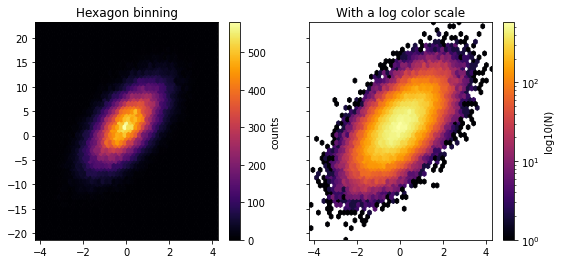

In [8]:
# --------------------
#  1 | CREATE THE PLOT
# --------------------
n = 100000
x = np.random.standard_normal(n)
y = 2.0 + 3.0 * x + 4.0 * np.random.standard_normal(n)
xlim = x.min(), x.max()
ylim = y.min(), y.max()

fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))

hb = ax0.hexbin(x, y, gridsize=50, cmap='inferno')
ax0.set(xlim=xlim, ylim=ylim)
ax0.set_title("Hexagon binning")
cb = fig.colorbar(hb, ax=ax0, label='counts')

hb = ax1.hexbin(x, y, gridsize=50, bins='log', cmap='inferno')
ax1.set(xlim=xlim, ylim=ylim)
ax1.set_title("With a log color scale")
cb = fig.colorbar(hb, ax=ax1, label='log10(N)')

# --------------------
#  2 | SAVE THE PLOT
# --------------------
plt.savefig('sample.png')

# src: https://matplotlib.org/stable/gallery/statistics/hexbin_demo.html

In [9]:
# --------------------
#  3 |  SEND THE PLOT
# --------------------
ht.notify(img = 'sample.png')

I suggest you use this method if you want to keep the plot.

#### 2) **auto**

For some selected libraries, I provide a function that automatically manages the library method.
The syntax is very similar: `ht.plotify( PLOT_MODULE )`.

<br>

**Supported libraries**
| library | note |
| :---:   | ---  |
| **matplotlib** | both plt and fig objects are supported |


Let's see an example with Matplotlib.

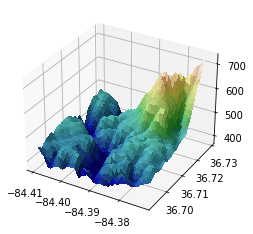

In [10]:
# --------------------
#  1 | CREATE THE PLOT
# --------------------
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource

# Load and format data
dem = cbook.get_sample_data('jacksboro_fault_dem.npz', np_load=True)
z = dem['elevation']
nrows, ncols = z.shape
x = np.linspace(dem['xmin'], dem['xmax'], ncols)
y = np.linspace(dem['ymin'], dem['ymax'], nrows)
x, y = np.meshgrid(x, y)

region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

# --------------------
#     don't save!
# --------------------
#plt.show()

# src: https://matplotlib.org/stable/gallery/mplot3d/custom_shaded_3d_surface.html

In [11]:
ht.plotify( fig, txt = 'your caption')

<br><br>

Let's try another time... but let's suppose that we want also to **save the picture** and **provide some arguments** to the plot function.

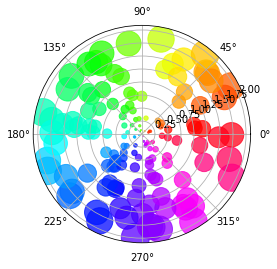

In [12]:
N = 150
r = 2 * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
area = 200 * r**2
colors = theta

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)

# src: https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_scatter.html

In [13]:
ht.plotify( fig, quiet = True,    # do not notify with sound :)
            keep = True,   # this will save the picture on file
            txt = 'saved on file',            # message caption
            dpi=200)      # argument passed to the plt function

[task] writing picture to demo_17-47-41.png


If you want to use a **custom file name**, input keep as string:
```python
ht.plotify( fig, keep = 'filename.png' )
```

<br>

## **Waypoints**

Waypoints are instructions that send a short notification with a progressive counter.

Let us consider a code which takes a while to be executed, and we want to be notified for each completed stage.

<br>
I know that I'm sending you a lot a messages. From now on, for the sake of quietness, let me disable the sound of notifications.

In [14]:
ht.set_allquiet(True)
# Note:  ht.set_allquiet(False)  would revert it


In [15]:
print('this takes 5 seconds to execute ...')
time.sleep(5)
print('... done')

this takes 5 seconds to execute ...
... done


In [16]:
ht.waypoint()

If you look now at your Telegram, you should have received a message like: 

<pre style="background-color: #b8f0ff; max-width:200px;">
[7QOLM0B]
 waypoint #1
</pre>

Let's wait some more time, then we call again a waypoint.

In [17]:
print('this takes 2 seconds to execute ...')
time.sleep(2)
print('... done')

this takes 2 seconds to execute ...
... done


In [18]:
ht.waypoint()

The new telegram message is

<pre style="background-color: #b8f0ff; max-width:200px;">
[7QOLM0B]
 waypoint #2
</pre>

<br>

A waypoint can also include the **elapsed time** between two waypoints:

In [19]:
time.sleep(2)
ht.waypoint(timed = True)

<pre style="background-color: #b8f0ff; max-width:200px;">
[7QOLM0B]
 waypoint #3
 + 3s
</pre>

Of course this option is more useful if the elapsed time is bigger. The printed time automatically adapts to the time interval; for instance, if the execution takes 38 minutes:
<pre style="background-color: #b8f0ff; max-width:200px;">
[7QOLM0B]
 waypoint #3
 + 38m 54s
</pre>

You can **reset the waypoint counter** using the optional argument
```python
ht.waypoint(reset = True) # this will also send a notification
```
or by calling the method
```python
ht.wpclear() # just reset the counter
```

In [20]:
ht.wpclear()

<br>

Finally, a waypoint can include a **custom txt** message.

In [21]:
ht.waypoint(txt = 'making good progress here!')

<pre style="background-color: #b8f0ff; max-width:400px;">
[7QOLM0B]
 waypoint #1 making good progress here!
</pre>

<br>

## **Close the task**

At the end of your code, it can be helpful to mark the task as completed.

In [22]:
ht.close()

You would receive a message like
<pre style="background-color: #b8f0ff; max-width:400px;">
Task 0H0IATR has been closed
</pre>

The task can be marked also as **completed with errors**:

In [23]:
ht.close(fail = 'error in quantum circuit 2')

In this case the fail message will be included in the text:
<pre style="background-color: #b8f0ff; max-width:400px;">
Task 0H0IATR has failed
 err: [error in quantum circuit 2]
</pre>

Note: **closing a task will not destroy the object**. It is just an utility to mark the task as completed and send a notification. This is helpful when you integrate Hermes tasks with your Hermes bot.

***

Code by *Francesco Barone*, last review: 13 august 2022.
<br> **Hermes** - Open Access Licence [GitHub](https://github.com/baronefr/hermes)